**ORIGINAL**

In [1]:
# Liberias
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dateutil.relativedelta import relativedelta

from collections import defaultdict

import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import time
import shap

In [2]:
# Cargo archivos csv
# Directorio que contiene los archivos
directorio = 'C:/Users/juanm/Desktop/Belcorp/EDA Promociones'

# Lista para almacenar los dataframes de cada archivo
dfs = []

# Recorre todos los archivos en el directorio
for archivo in os.listdir(directorio):
    if "Input EDA (con UU original)" in archivo and archivo.endswith('.csv'):
        ruta_archivo = os.path.join(directorio, archivo)
        df = pd.read_csv(ruta_archivo)  # Lee el archivo Excel y lo convierte en un dataframe
        dfs.append(df)

# Concatena todos los dataframes en uno solo
df = pd.concat(dfs, ignore_index=True)

In [3]:
# Check y eliminacion de duplicados
numero_duplicados = df.duplicated().sum()
print(f'Número de filas duplicadas eliminadas: {numero_duplicados}')

Número de filas duplicadas eliminadas: 0


In [4]:
# Elimino columnas no digitales
df.drop(
['COD_PAIS',
'COD_PERIODO',
'ID_OFERTA_AE'
], axis='columns', inplace=True)

In [5]:
# Valores nulos
print(df.isnull().sum())

REAL_UNIDADES_VENDIDAS          680
COUNT(DISTINCT COD_CATALOGO)      0
N_OFERTAS_DIG                     0
N_OFERTAS_REV                     0
N_OFERTAS_CAT                     0
COUNT(DISTINCT DESMARCA)          0
N_OFERTAS_ESIKA                   0
N_OFERTAS_CYZONE                  0
N_OFERTAS_LBEL                    0
dtype: int64


In [6]:
# Imputo nulos
columnas_imputar = [
     'REAL_UNIDADES_VENDIDAS'
]

# Reemplazar los valores nulos por 0 en las columnas especificadas
df[columnas_imputar] = df[columnas_imputar].fillna(0)

In [7]:
# Hago un split de la data

X = df.drop(['REAL_UNIDADES_VENDIDAS'], axis=1)
y = df['REAL_UNIDADES_VENDIDAS']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state = 42)

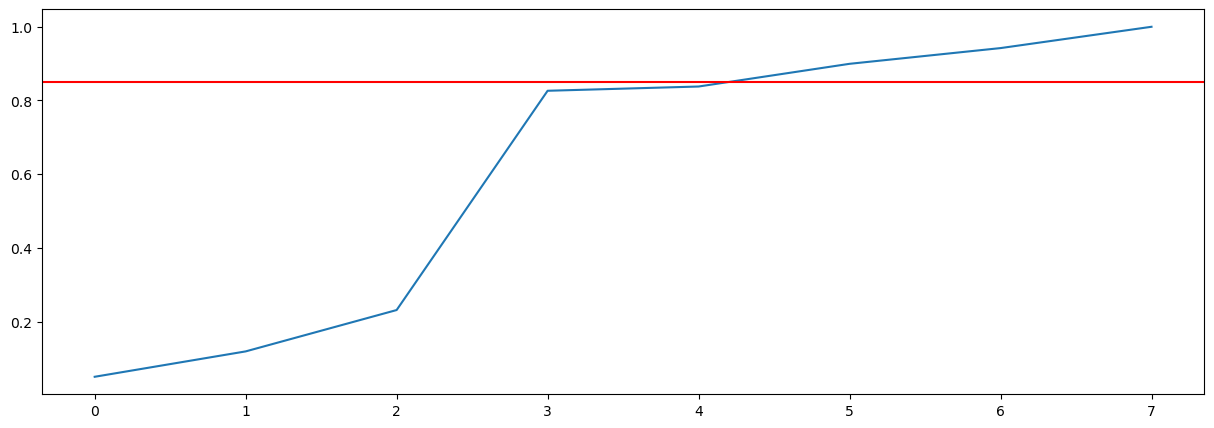

In [8]:
# Entrenar el modelo RandomForestRegressor para determinar la importancia acumulada de los atributos
model_rf = ensemble.RandomForestRegressor(n_jobs=-1, n_estimators = 100, random_state=42)
model_rf.fit(X_train, y_train)

# Importancia acumulada de las características
cumulative_importance = np.cumsum(model_rf.feature_importances_)

# Graficar la importancia acumulada
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(111)
plt.plot(cumulative_importance)
plt.axhline(0.85, color='r')
plt.show()

# Determinar el número de características necesarias para alcanzar el 85% de importancia acumulada
NUM_OF_FEATURES = np.argmax(cumulative_importance >= 0.85) + 1

In [9]:
NUM_OF_FEATURES

6

In [10]:
# Seleccionar las características más importantes
col = pd.DataFrame({'importance': model_rf.feature_importances_, 'feature': X_train.columns}).sort_values(
    by=['importance'], ascending=[False])[:NUM_OF_FEATURES]['feature'].values

X_train_selected = X_train[col]
X_test_selected = X_test[col]

# Definir la función de evaluación y la clase de ensamble
NUM_FOLDS = 5
def rmsle_cv(model):
    kf = KFold(NUM_FOLDS, shuffle=True, random_state=42).get_n_splits(X_train_selected.values)
    rmse = np.sqrt(-cross_val_score(model, X_train_selected, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]  
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

# Definir los modelos de XGBoost y LightGBM
model_xgb = xgb.XGBRegressor(colsample_bytree=0.055, 
                             gamma=1.5, 
                             learning_rate=0.02, 
                             max_depth=12, 
                             n_estimators=1000,
                             subsample=0.7, 
                             objective='reg:linear',
                             booster='gbtree',
                             reg_alpha=0.0, 
                             eval_metric='rmse', 
                             silent=1, 
                             random_state=7)

model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=144,
                              learning_rate=0.005, 
                              n_estimators=1000, 
                              max_depth=12,
                              metric='rmse',
                              is_training_metric=True,
                              max_bin=55, 
                              bagging_fraction=0.8,
                              verbose=-1,
                              bagging_freq=5, 
                              feature_fraction=0.9)

# Evaluar los modelos
l_m = []
l_std = []
time_d = {}

start = time.time()
score_1_xgb = rmsle_cv(model_xgb)
end = time.time()

l_m.append(score_1_xgb.mean())
l_std.append(score_1_xgb.std())
time_d['XGB'] = end - start
print("    Xgboost score : {:.4f} ({:.4f})".format(score_1_xgb.mean(), score_1_xgb.std()))

start = time.time()
score_1_lgb = rmsle_cv(model_lgb)
end = time.time()

l_m.append(score_1_lgb.mean())
l_std.append(score_1_lgb.std())
time_d['LGB'] = end - start
print("    LGBM score    : {:.4f} ({:.4f})".format(score_1_lgb.mean(), score_1_lgb.std()))

# Ensamble de modelos
averaged_models_1 = AveragingModels(models=(model_xgb, model_lgb))

score_1 = rmsle_cv(averaged_models_1)

l_m.append(score_1.mean())
l_std.append(score_1.std())
print("    Averaged score: {:.4f} ({:.4f})\n".format(score_1.mean(), score_1.std()))

    Xgboost score : 213220.1155 (13012.6246)
    LGBM score    : 176308.5000 (12320.8720)
    Averaged score: 186181.2132 (12784.8911)



In [11]:
# Mejor modelo

model_lgb.fit(X_train_selected.values, y_train)
pred = model_lgb.predict(X_test_selected.values)

In [12]:
# Cargo shap
shap.initjs()

In [13]:
# Using a random sample of the dataframe for better time computation
X_sampled = X_train_selected.sample(100, random_state=10)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model_lgb)
# shap_values = explainer.shap_values(X_sampled)
shap_values = explainer.shap_values(X_sampled)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_selected.iloc[0,:])

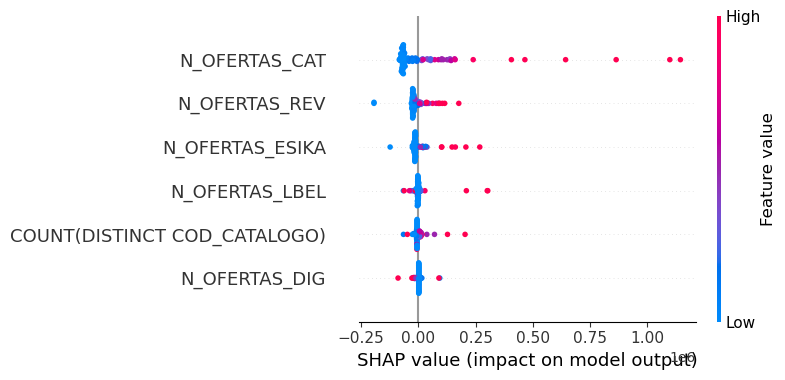

In [14]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

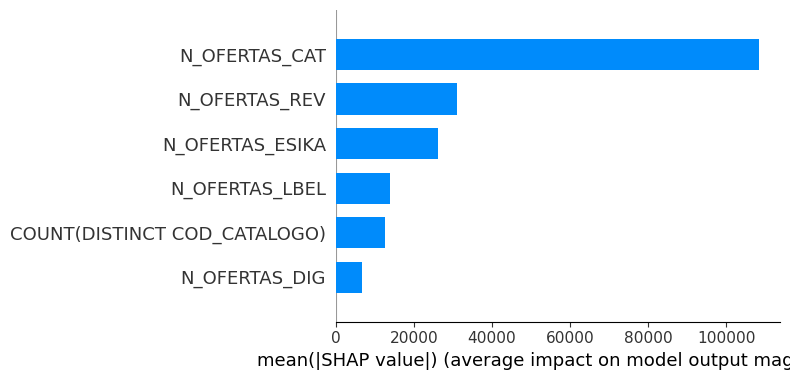

In [15]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

In [16]:
# Importo libreria
import ppscore as pps

# Calcular el PPS para todas las variables respecto a 'REAL_UNIDADES_VENDIDAS'
pps_matrix = pps.matrix(df)[['x', 'y', 'ppscore']]

# Filtrar solo las filas donde 'y' es 'REAL_UNIDADES_VENDIDAS'
pps_target = pps_matrix[pps_matrix['y'] == 'REAL_UNIDADES_VENDIDAS']

# Ordenar los resultados por el ppscore
pps_target_sorted = pps_target.sort_values(by='ppscore', ascending=False)

# Mostrar los resultados
pps_target_sorted

,x,y,ppscore
0,REAL_UNIDADES_VENDIDAS,REAL_UNIDADES_VENDIDAS,1.000000
36,N_OFERTAS_CAT,REAL_UNIDADES_VENDIDAS,0.173827
27,N_OFERTAS_REV,REAL_UNIDADES_VENDIDAS,0.155473
9,COUNT(DISTINCT COD_CATALOGO),REAL_UNIDADES_VENDIDAS,0.026298
18,N_OFERTAS_DIG,REAL_UNIDADES_VENDIDAS,0.000000
45,COUNT(DISTINCT DESMARCA),REAL_UNIDADES_VENDIDAS,0.000000
54,N_OFERTAS_ESIKA,REAL_UNIDADES_VENDIDAS,0.000000
63,N_OFERTAS_CYZONE,REAL_UNIDADES_VENDIDAS,0.000000
72,N_OFERTAS_LBEL,REAL_UNIDADES_VENDIDAS,0.000000


**NUEVAS VARIABLES**

In [17]:
# Liberias
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dateutil.relativedelta import relativedelta

from collections import defaultdict

import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import time
import shap

In [18]:
# Cargo archivos csv
# Directorio que contiene los archivos
directorio = 'C:/Users/juanm/Desktop/Belcorp/EDA Promociones'

# Lista para almacenar los dataframes de cada archivo
dfs = []

# Recorre todos los archivos en el directorio
for archivo in os.listdir(directorio):
    if "Input EDA (con UU y nuevas variables)" in archivo and archivo.endswith('.csv'):
        ruta_archivo = os.path.join(directorio, archivo)
        df = pd.read_csv(ruta_archivo)  # Lee el archivo Excel y lo convierte en un dataframe
        dfs.append(df)

# Concatena todos los dataframes en uno solo
df = pd.concat(dfs, ignore_index=True)

In [19]:
# Genero dummies

dummies_TIPO_FCP = pd.get_dummies(df['TIPO_FCP'], prefix='TIPO_FCP')
dummies_DES_TIPO_SUBESTRATEGIA = pd.get_dummies(df['DES_TIPO_SUBESTRATEGIA'], prefix='DES_TIPO_SUBESTRATEGIA')
dummies_DES_TIPO_ESTRATEGIA = pd.get_dummies(df['DES_TIPO_ESTRATEGIA'], prefix='DES_TIPO_ESTRATEGIA')
dummies_DES_TIPO_GRUPO = pd.get_dummies(df['DES_TIPO_GRUPO'], prefix='DES_TIPO_GRUPO')
dummies_ALCANCE = pd.get_dummies(df['ALCANCE'], prefix='ALCANCE')
dummies_TARGET = pd.get_dummies(df['TARGET'], prefix='TARGET')


df = pd.concat([df, dummies_TIPO_FCP, dummies_DES_TIPO_SUBESTRATEGIA, dummies_DES_TIPO_ESTRATEGIA, dummies_DES_TIPO_GRUPO, dummies_ALCANCE, dummies_TARGET], axis=1)

In [20]:
# Check y eliminacion de duplicados
numero_duplicados = df.duplicated().sum()
print(f'Número de filas duplicadas eliminadas: {numero_duplicados}')

Número de filas duplicadas eliminadas: 0


In [21]:
# Elimino columnas no digitales
df.drop(
['COD_PAIS',
'COD_PERIODO',
'ID_OFERTA_AE',
'TIPO_FCP',
'DES_TIPO_SUBESTRATEGIA',
'DES_TIPO_ESTRATEGIA',
'DES_TIPO_GRUPO',
'ALCANCE',
'TARGET',
'COD_TIPO_PROFIT',
'VALOR_INI',
'VALOR_FIN',
'COD_TIPO_OFERTA'
], axis='columns', inplace=True)

In [22]:
# Valores nulos
print(df.isnull().sum())

ID_TIPO_ACCION                                       0
ID_TIPO_CONDICION                                    0
COD_CATALOGO                                         0
REAL_UNIDADES_VENDIDAS                           72810
COUNT(DISTINCT COD_CATALOGO)                         0
N_OFERTAS_DIG                                        0
N_OFERTAS_REV                                        0
N_OFERTAS_CAT                                        0
COUNT(DISTINCT DESMARCA)                             0
N_OFERTAS_ESIKA                                      0
N_OFERTAS_CYZONE                                     0
N_OFERTAS_LBEL                                       0
TIPO_FCP_FIJO                                        0
TIPO_FCP_RANGO                                       0
DES_TIPO_SUBESTRATEGIA_993                           0
DES_TIPO_SUBESTRATEGIA_996                           0
DES_TIPO_SUBESTRATEGIA_INDIVIDUAL                    0
DES_TIPO_SUBESTRATEGIA_INDIVIDUAL + ADICIONAL        0
DES_TIPO_S

In [23]:
# Imputo nulos
columnas_imputar = [
     'REAL_UNIDADES_VENDIDAS'
]

# Reemplazar los valores nulos por 0 en las columnas especificadas
df[columnas_imputar] = df[columnas_imputar].fillna(0)

In [24]:
# Hago un split de la data

X = df.drop(['REAL_UNIDADES_VENDIDAS'], axis=1)
y = df['REAL_UNIDADES_VENDIDAS']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state = 42)

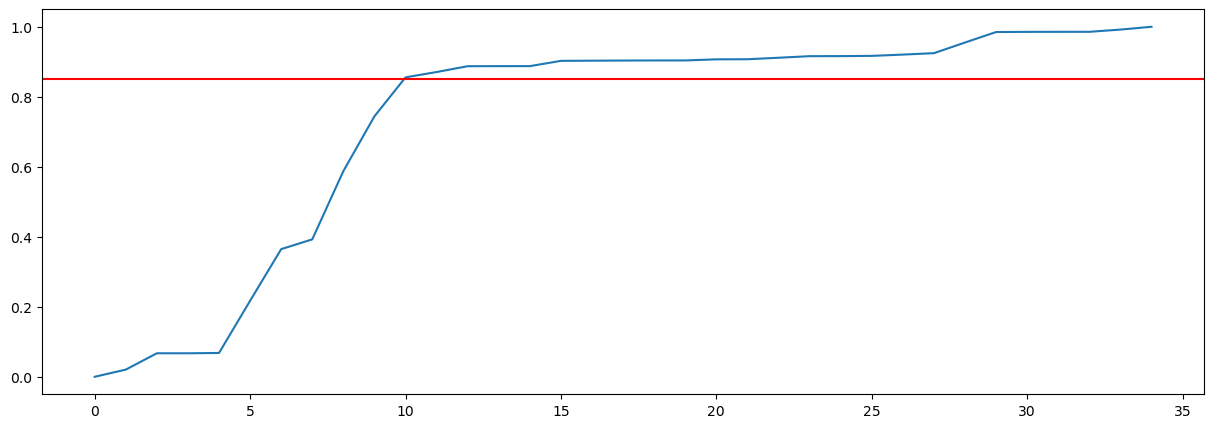

In [25]:
# Entrenar el modelo RandomForestRegressor para determinar la importancia acumulada de los atributos
model_rf = ensemble.RandomForestRegressor(n_jobs=-1, n_estimators = 100, random_state=42)
model_rf.fit(X_train, y_train)

# Importancia acumulada de las características
cumulative_importance = np.cumsum(model_rf.feature_importances_)

# Graficar la importancia acumulada
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(111)
plt.plot(cumulative_importance)
plt.axhline(0.85, color='r')
plt.show()

# Determinar el número de características necesarias para alcanzar el 85% de importancia acumulada
NUM_OF_FEATURES = np.argmax(cumulative_importance >= 0.85) + 1

In [26]:
NUM_OF_FEATURES

11

In [27]:
# Seleccionar las características más importantes
col = pd.DataFrame({'importance': model_rf.feature_importances_, 'feature': X_train.columns}).sort_values(
    by=['importance'], ascending=[False])[:NUM_OF_FEATURES]['feature'].values

X_train_selected = X_train[col]
X_test_selected = X_test[col]

# Definir la función de evaluación y la clase de ensamble
NUM_FOLDS = 5
def rmsle_cv(model):
    kf = KFold(NUM_FOLDS, shuffle=True, random_state=42).get_n_splits(X_train_selected.values)
    rmse = np.sqrt(-cross_val_score(model, X_train_selected, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]  
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

# Definir los modelos de XGBoost y LightGBM
model_xgb = xgb.XGBRegressor(colsample_bytree=0.055, 
                             gamma=1.5, 
                             learning_rate=0.02, 
                             max_depth=12, 
                             n_estimators=1000,
                             subsample=0.7, 
                             objective='reg:linear',
                             booster='gbtree',
                             reg_alpha=0.0, 
                             eval_metric='rmse', 
                             silent=1, 
                             random_state=7)

model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=144,
                              learning_rate=0.005, 
                              n_estimators=1000, 
                              max_depth=12,
                              metric='rmse',
                              is_training_metric=True,
                              max_bin=55, 
                              bagging_fraction=0.8,
                              verbose=-1,
                              bagging_freq=5, 
                              feature_fraction=0.9)

# Evaluar los modelos
l_m = []
l_std = []
time_d = {}

start = time.time()
score_1_xgb = rmsle_cv(model_xgb)
end = time.time()

l_m.append(score_1_xgb.mean())
l_std.append(score_1_xgb.std())
time_d['XGB'] = end - start
print("    Xgboost score : {:.4f} ({:.4f})".format(score_1_xgb.mean(), score_1_xgb.std()))

start = time.time()
score_1_lgb = rmsle_cv(model_lgb)
end = time.time()

l_m.append(score_1_lgb.mean())
l_std.append(score_1_lgb.std())
time_d['LGB'] = end - start
print("    LGBM score    : {:.4f} ({:.4f})".format(score_1_lgb.mean(), score_1_lgb.std()))

# Ensamble de modelos
averaged_models_1 = AveragingModels(models=(model_xgb, model_lgb))

score_1 = rmsle_cv(averaged_models_1)

l_m.append(score_1.mean())
l_std.append(score_1.std())
print("    Averaged score: {:.4f} ({:.4f})\n".format(score_1.mean(), score_1.std()))

    Xgboost score : 20829.6931 (544.6556)
    LGBM score    : 18727.0497 (552.3540)
    Averaged score: 19362.9167 (497.7429)



In [28]:
# Mejor modelo

model_lgb.fit(X_train_selected.values, y_train)
pred = model_lgb.predict(X_test_selected.values)

In [29]:
# Using a random sample of the dataframe for better time computation
X_sampled = X_train_selected.sample(100, random_state=10)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model_lgb)
# shap_values = explainer.shap_values(X_sampled)
shap_values = explainer.shap_values(X_sampled)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_selected.iloc[0,:])

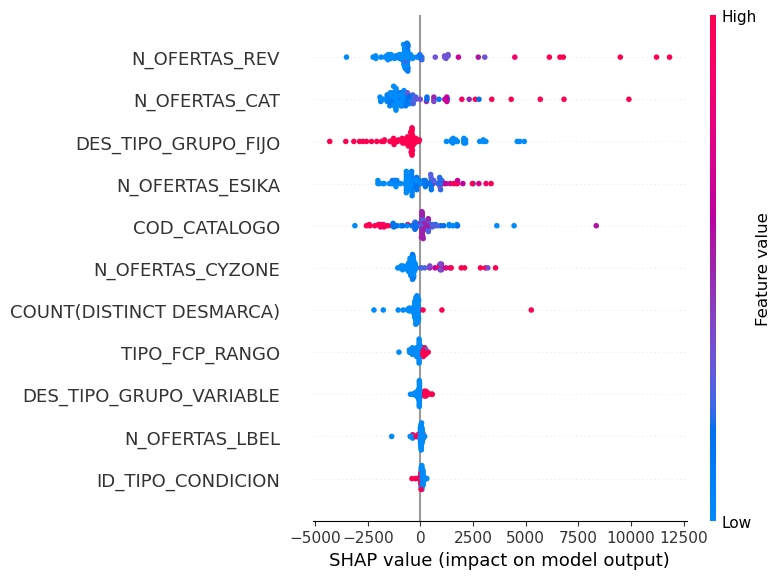

In [30]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

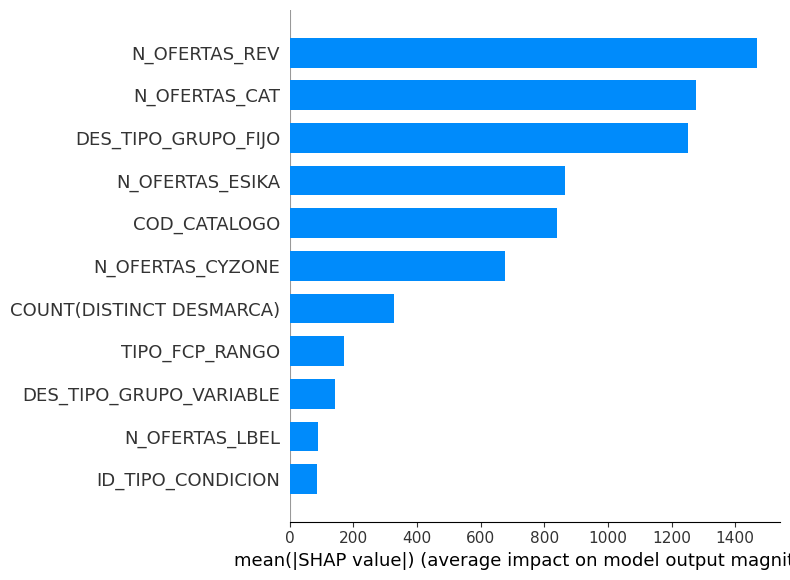

In [31]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")